In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
beta = np.array([-0.30, 0.30, 0.70, 1.00, 1.50, 2.50])
sigma_tilde = np.array([0.15, 0.16, 0.10, 0.11, 0.12, 0.14])
sigma_m, mu_m, r_f = 0.20, 0.08, 0.02

In [3]:
mu = r_f + beta * (mu_m - r_f)
mu

array([0.002, 0.038, 0.062, 0.08 , 0.11 , 0.17 ])

In [4]:
var_m = sigma_m ** 2
sigma_epsilon_squared = sigma_tilde ** 2
cov_matrix = np.outer(beta, beta) * var_m
np.fill_diagonal(cov_matrix, np.diag(cov_matrix) + sigma_epsilon_squared)
cov_matrix

array([[ 0.0261, -0.0036, -0.0084, -0.012 , -0.018 , -0.03  ],
       [-0.0036,  0.0292,  0.0084,  0.012 ,  0.018 ,  0.03  ],
       [-0.0084,  0.0084,  0.0296,  0.028 ,  0.042 ,  0.07  ],
       [-0.012 ,  0.012 ,  0.028 ,  0.0521,  0.06  ,  0.1   ],
       [-0.018 ,  0.018 ,  0.042 ,  0.06  ,  0.1044,  0.15  ],
       [-0.03  ,  0.03  ,  0.07  ,  0.1   ,  0.15  ,  0.2696]])

In [5]:
sigma = np.sqrt(np.diag(cov_matrix))
sigma

array([0.16155494, 0.17088007, 0.17204651, 0.22825424, 0.32310989,
       0.5192302 ])

In [6]:
correlation_matrix = cov_matrix / np.outer(sigma, sigma)
correlation_matrix

array([[ 1.        , -0.13040397, -0.30221302, -0.32541842, -0.34482759,
        -0.35763586],
       [-0.13040397,  1.        ,  0.2857209 ,  0.30765995,  0.32600993,
         0.33811924],
       [-0.30221302,  0.2857209 ,  1.        ,  0.71300621,  0.75553256,
         0.78359605],
       [-0.32541842,  0.30765995,  0.71300621,  1.        ,  0.81354605,
         0.84376439],
       [-0.34482759,  0.32600993,  0.75553256,  0.81354605,  1.        ,
         0.89408965],
       [-0.35763586,  0.33811924,  0.78359605,  0.84376439,  0.89408965,
         1.        ]])

In [7]:
sharpe_ratio = (mu - r_f) / sigma
sharpe_ratio

array([-0.1114172 ,  0.10533703,  0.24412004,  0.26286477,  0.27854301,
        0.28888921])

In [8]:
n = 6
x = cp.Variable(n)
constraints = [cp.sum(x) == 1, x >= -10, x <= 10]

gamma_values = [0, 0.10, 0.20, 0.5, 1]
results = []
for gamma in gamma_values:
    objective = cp.Minimize(0.5 * cp.quad_form(x, cov_matrix) - gamma * (mu - r_f) @ x)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value
    
    mu_x = np.dot(mu, x_opt)
    sigma_x = np.sqrt(x_opt @ cov_matrix @ x_opt)
    sharpe_x = (mu_x - r_f) / sigma_x

    print(f"Portfolio: {x_opt}")
    print(f"Gamma: {gamma}")
    print(f"Expected Return: {mu_x:.4f}")
    print(f"Volatility: {sigma_x:.4f}")
    print(f"Sharpe Ratio: {sharpe_x:.4f}")
    print('\n')

Portfolio: [ 0.33295234  0.20351853  0.36891722  0.21061947  0.0449561  -0.16096366]
Gamma: 0
Expected Return: 0.0257
Volatility: 0.0797
Sharpe Ratio: 0.0716


Portfolio: [ 0.2999226   0.1879909   0.35221061  0.2110959   0.06536001 -0.11658001]
Gamma: 0.1
Expected Return: 0.0338
Volatility: 0.0846
Sharpe Ratio: 0.1635


Portfolio: [ 0.26689285  0.17246327  0.33550399  0.21157233  0.08576393 -0.07219636]
Gamma: 0.2
Expected Return: 0.0420
Volatility: 0.0980
Sharpe Ratio: 0.2242


Portfolio: [0.16780362 0.12588037 0.28538415 0.21300162 0.14697567 0.06095458]
Gamma: 0.5
Expected Return: 0.0664
Volatility: 0.1634
Sharpe Ratio: 0.2839


Portfolio: [0.00265489 0.04824221 0.20185108 0.21538376 0.24899524 0.28287281]
Gamma: 1
Expected Return: 0.1071
Volatility: 0.2962
Sharpe Ratio: 0.2940




In [9]:
n = 6
x = cp.Variable(n)
constraints = [cp.sum(x) == 1, x >= -10, x <= 10]

gamma_values = np.arange(-0.5, 10.1, 0.01)
long_short_portfolios = []
for gamma in gamma_values:
    objective = cp.Minimize(0.5 * cp.quad_form(x, cov_matrix) - gamma * (mu - r_f) @ x)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value

    mu_x = np.dot(mu, x_opt)
    sigma_x = np.sqrt(x_opt @ cov_matrix @ x_opt)

    long_short_portfolios.append([mu_x, sigma_x])

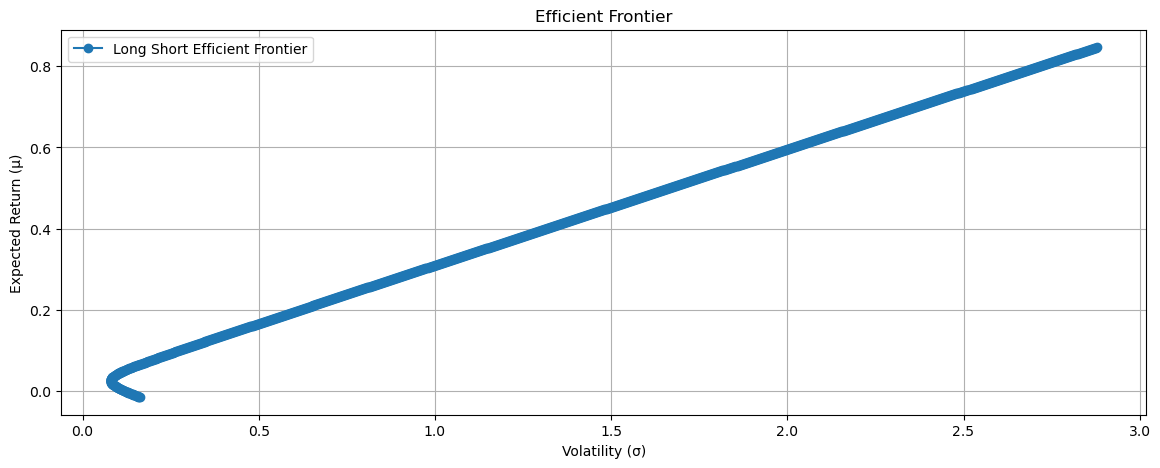

In [10]:
long_short_portfolios = np.array(long_short_portfolios)

expected_returns_long_short = long_short_portfolios[:, 0]
volatilities_long_short = long_short_portfolios[:, 1]

plt.figure(figsize=(14, 5))
plt.plot(volatilities_long_short, expected_returns_long_short, marker='o', linestyle='-', label="Long Short Efficient Frontier")
plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.title("Efficient Frontier")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def long_short_solver(gamma, cov_matrix, mu, r_f):
    n = 6
    x = cp.Variable(n)
    constraints = [cp.sum(x) == 1, x >= -10, x <= 10]
    
    objective = cp.Minimize(0.5 * cp.quad_form(x, cov_matrix) - gamma * (mu - r_f) @ x)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value
    
    mu_x = np.dot(mu, x_opt)
    sigma_x = np.sqrt(x_opt @ cov_matrix @ x_opt)
    sharpe_x = (mu_x - r_f) / sigma_x

    return x_opt, mu_x, sigma_x, sharpe_x

In [12]:
gamma0, gamma1 = -0.5, 10
volatility_target = 0.1

while (gamma1 - gamma0) > 1e-7:
    midpoint = (gamma0 + gamma1) / 2
    _, _, vol, _ = long_short_solver(midpoint, cov_matrix, mu, r_f)

    if vol > volatility_target:
        gamma1 = midpoint
    else:
        gamma0 = midpoint

gamma = (gamma0 + gamma1) / 2
portfolio, mu_target, sigma_target, sharpe_target = long_short_solver(gamma, cov_matrix, mu, r_f)

print(f"Portfolio: {portfolio}")
print(f"Gamma: {gamma}")
print(f"Expected Return: {mu_target:.4f}")
print(f"Volatility: {sigma_target:.4f}")
print(f"Sharpe Ratio: {sharpe_target:.4f}")

Portfolio: [ 0.26299945  0.17063294  0.33353469  0.21162849  0.08816905 -0.06696462]
Gamma: 0.21178754605352879
Expected Return: 0.0429
Volatility: 0.1000
Sharpe Ratio: 0.2293


In [13]:
gamma0, gamma1 = -0.5, 10
volatility_target = 0.15

while (gamma1 - gamma0) > 1e-7:
    midpoint = (gamma0 + gamma1) / 2
    _, _, vol, _ = long_short_solver(midpoint, cov_matrix, mu, r_f)

    if vol > volatility_target:
        gamma1 = midpoint
    else:
        gamma0 = midpoint

gamma = (gamma0 + gamma1) / 2
portfolio, mu_target, sigma_target, sharpe_target = long_short_solver(gamma, cov_matrix, mu, r_f)

print(f"Portfolio: {portfolio}")
print(f"Gamma: {gamma}")
print(f"Expected Return: {mu_target:.4f}")
print(f"Volatility: {sigma_target:.4f}")
print(f"Sharpe Ratio: {sharpe_target:.4f}")

Portfolio: [0.18579564 0.13433861 0.29448461 0.21274209 0.13586121 0.03677784]
Gamma: 0.44552782364189625
Expected Return: 0.0620
Volatility: 0.1500
Sharpe Ratio: 0.2797


In [14]:
tangency_portfolio = np.linalg.inv(cov_matrix) @ (mu - r_f) / (np.ones(6) @ np.linalg.inv(cov_matrix) @ (mu - r_f))
gamma = 1 / (np.ones(6) @ np.linalg.inv(cov_matrix) @ (mu - r_f))
mu_tangency = np.dot(mu, tangency_portfolio)
sigma_tangency = np.sqrt(tangency_portfolio @ cov_matrix @ tangency_portfolio)
sharpe_tangency = (mu_tangency - r_f) / sigma_tangency

print(f"Portfolio: {tangency_portfolio}")
print(f"Gamma: {gamma}")
print(f"Expected Return: {mu_tangency:.4f}")
print(f"Volatility: {sigma_tangency:.4f}")
print(f"Sharpe Ratio: {sharpe_tangency:.4f}")

Portfolio: [-0.03483583  0.03061743  0.18288809  0.21592454  0.27215489  0.33325089]
Gamma: 1.1135059308214783
Expected Return: 0.1163
Volatility: 0.3275
Sharpe Ratio: 0.2941


In [15]:
gamma_values = np.arange(-0.5, 10, 0.01)
sharpe0 = -1e7

for gamma in gamma_values:
    _, _, _, sharpe_temp = long_short_solver(gamma, cov_matrix, mu, r_f)

    if sharpe_temp > sharpe0:
        sharpe0 = sharpe_temp
        gamma0 = gamma

In [16]:
gamma_values = np.arange(gamma0 - 0.01, gamma0 + 0.01, 0.0001)
for gamma in gamma_values:
    tangency_temp, mu_temp, sigma_temp, sharpe_temp = long_short_solver(gamma, cov_matrix, mu, r_f)

    if sharpe_temp > sharpe0:
        tangency_brute, mu_brute, sigma_brute, sharpe_brute = tangency_temp, mu_temp, sigma_temp, sharpe_temp
        gamma0 = gamma
        sharpe0 = sharpe_brute

print(f"Portfolio: {tangency_brute}")
print(f"Gamma: {gamma0}")
print(f"Expected Return: {mu_brute:.4f}")
print(f"Volatility: {sigma_brute:.4f}")
print(f"Sharpe Ratio: {sharpe_brute:.4f}")

Portfolio: [-0.03483387  0.03061835  0.18288908  0.21592451  0.27215368  0.33324825]
Gamma: 1.1135
Expected Return: 0.1163
Volatility: 0.3275
Sharpe Ratio: 0.2941


In [17]:
mu_f = np.append(mu, r_f)

zero_n = np.zeros((n, 1))
cov_matrix_f = np.block([
    [cov_matrix, zero_n],
    [zero_n.T, np.array([[0]])]
])

In [18]:
n = 7
x = cp.Variable(n)
constraints = [cp.sum(x) == 1, x >= -10, x <= 10]

gamma_values = np.arange(0.5, 1.5, 0.01)
extended_portfolios = []
sharpe_ratio_values = []
tangency_brute = None
for gamma in gamma_values:
    objective = cp.Minimize(0.5 * cp.quad_form(x, cov_matrix_f) - gamma * mu_f @ x)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value

    if x_opt[6] < 0 and tangency_brute is None:
        tangency_brute = x_opt
        gamma0 = gamma

    mu_x = np.dot(mu_f, x_opt)
    sigma_x = np.sqrt(x_opt @ cov_matrix_f @ x_opt)
    sharpe_x = (mu_x - r_f) / sigma_x

    extended_portfolios.append([mu_x, sigma_x])
    sharpe_ratio_values.append(sharpe_x)

In [19]:
gamma_values = np.arange(gamma0 - 0.01, gamma0 + 0.01, 0.0001)
tangency_brute = None
for gamma in gamma_values:
    objective = cp.Minimize(0.5 * cp.quad_form(x, cov_matrix_f) - gamma * mu_f @ x)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value

    if x_opt[6] < 0 and tangency_brute is None:
        tangency_brute = x_opt
        gamma0 = gamma
        break

In [20]:
sharpe_ratio_values[:10]

[0.2940755998596355,
 0.29407559985963555,
 0.2940755998596355,
 0.2940755998596355,
 0.29407559985963555,
 0.2940755998596355,
 0.2940755998596355,
 0.2940755998596355,
 0.2940755998596355,
 0.29407559985963555]

In [21]:
mu_brute = np.dot(mu_f, tangency_brute)
sigma_brute = np.sqrt(tangency_brute @ cov_matrix_f @ tangency_brute)
sharpe_brute = (mu_brute - r_f) / sigma_brute

print(f"Portfolio: {tangency_brute}")
print(f"Gamma: {gamma0}")
print(f"Expected Return: {mu_brute:.4f}")
print(f"Volatility: {sigma_brute:.4f}")
print(f"Sharpe Ratio: {sharpe_brute:.4f}")

Portfolio: [-3.48387688e-02  3.06200116e-02  1.82903536e-01  2.15942782e-01
  2.72177881e-01  3.33279038e-01 -8.44801774e-05]
Gamma: 1.1136000000000001
Expected Return: 0.1163
Volatility: 0.3275
Sharpe Ratio: 0.2941


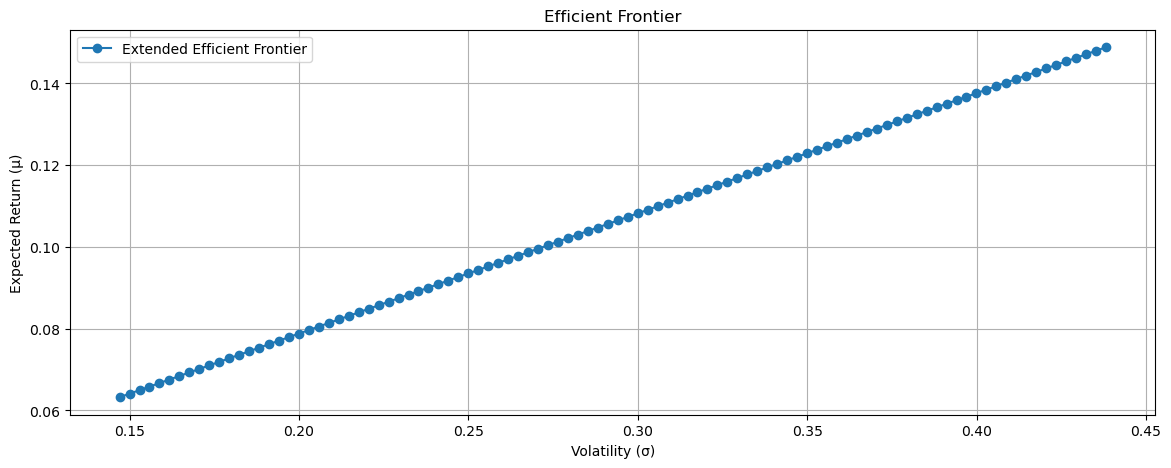

In [22]:
extended_portfolios = np.array(extended_portfolios)

expected_returns = extended_portfolios[:, 0]
volatilities = extended_portfolios[:, 1]

plt.figure(figsize=(14, 5))
plt.plot(volatilities, expected_returns, marker='o', linestyle='-', label="Extended Efficient Frontier")
plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.title("Efficient Frontier")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
n = 6
x = cp.Variable(n)
constraints = [cp.sum(x) == 1, x >= 0, x <= 1]

gamma_values = [0, 0.10, 0.20, 0.5, 1]
results = []
for gamma in gamma_values:
    objective = cp.Minimize(0.5 * cp.quad_form(x, cov_matrix) - gamma * (mu - r_f) @ x)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value
    
    mu_x = np.dot(mu, x_opt)
    sigma_x = np.sqrt(x_opt @ cov_matrix @ x_opt)
    sharpe_x = (mu_x - r_f) / sigma_x

    print(f"Portfolio: {x_opt}")
    print(f"Gamma: {gamma}")
    print(f"Expected Return: {mu_x:.4f}")
    print(f"Volatility: {sigma_x:.4f}")
    print(f"Sharpe Ratio: {sharpe_x:.4f}")
    print('\n')

Portfolio: [4.45838379e-01 2.22332734e-01 2.79862095e-01 5.19667916e-02
 1.92375296e-23 1.25202738e-22]
Gamma: 0
Expected Return: 0.0308
Volatility: 0.0887
Sharpe Ratio: 0.1224


Portfolio: [3.72128402e-01 2.02358192e-01 3.05202348e-01 1.20311059e-01
 1.79945498e-23 2.63763333e-23]
Gamma: 0.1
Expected Return: 0.0370
Volatility: 0.0921
Sharpe Ratio: 0.1845


Portfolio: [3.04177970e-01 1.81936997e-01 3.19997564e-01 1.74112978e-01
 1.97744916e-02 1.20238736e-24]
Gamma: 0.2
Expected Return: 0.0435
Volatility: 0.1022
Sharpe Ratio: 0.2296


Portfolio: [0.16780362 0.12588037 0.28538415 0.21300162 0.14697567 0.06095458]
Gamma: 0.5
Expected Return: 0.0664
Volatility: 0.1634
Sharpe Ratio: 0.2839


Portfolio: [0.00265489 0.04824221 0.20185108 0.21538376 0.24899524 0.28287281]
Gamma: 1
Expected Return: 0.1071
Volatility: 0.2962
Sharpe Ratio: 0.2940




In [24]:
n = 6
x = cp.Variable(n)
constraints = [cp.sum(x) == 1, x >= 0, x <= 1]

gamma_values = np.arange(-0.5, 10.1, 0.01)
long_only_portfolios = []
for gamma in gamma_values:
    objective = cp.Minimize(0.5 * cp.quad_form(x, cov_matrix) - gamma * (mu - r_f) @ x)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value

    mu_x = np.dot(mu, x_opt)
    sigma_x = np.sqrt(x_opt @ cov_matrix @ x_opt)

    long_only_portfolios.append([mu_x, sigma_x])

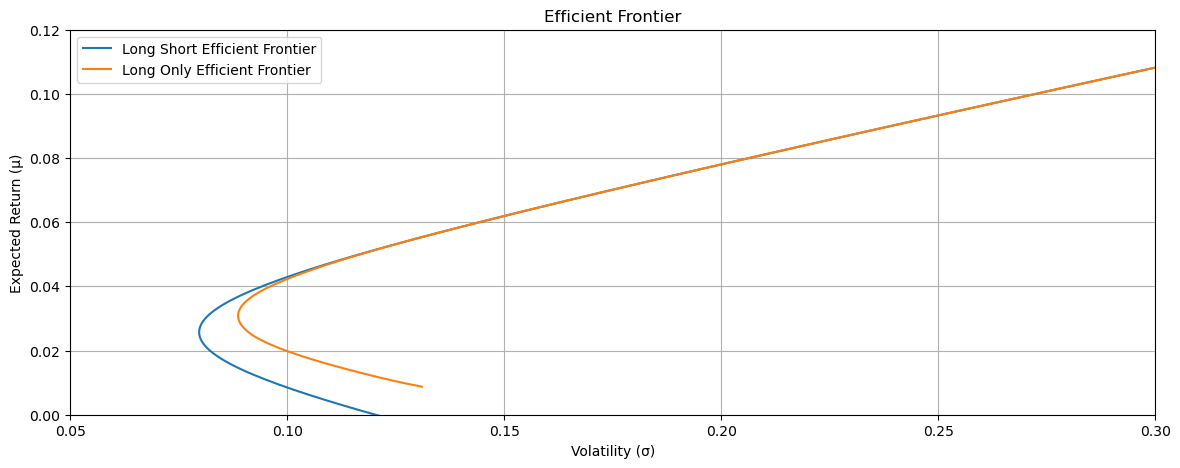

In [25]:
long_only_portfolios = np.array(long_only_portfolios)

expected_returns_long_only = long_only_portfolios[:, 0]
volatilities_long_only = long_only_portfolios[:, 1]

plt.figure(figsize=(14, 5))
plt.plot(volatilities_long_short, expected_returns_long_short, linestyle='-', label="Long Short Efficient Frontier")
plt.plot(volatilities_long_only, expected_returns_long_only, linestyle='-', label="Long Only Efficient Frontier")
plt.xlim(0.05, 0.3)
plt.ylim(0, 0.12)
plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.title("Efficient Frontier")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
def solver_long_only(gamma, cov_matrix, mu, r_f):
    n = 6
    x = cp.Variable(n)
    constraints = [cp.sum(x) == 1, x >= 0, x <= 1]
    
    objective = cp.Minimize(0.5 * cp.quad_form(x, cov_matrix) - gamma * (mu - r_f) @ x)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value
    
    mu_x = np.dot(mu, x_opt)
    sigma_x = np.sqrt(x_opt @ cov_matrix @ x_opt)
    sharpe_x = (mu_x - r_f) / sigma_x

    return x_opt, mu_x, sigma_x, sharpe_x

In [27]:
gamma0, gamma1 = -0.5, 10
volatility_target = 0.1

while (gamma1 - gamma0) > 1e-7:
    midpoint = (gamma0 + gamma1) / 2
    _, _, vol, _ = solver_long_only(midpoint, cov_matrix, mu, r_f)

    if vol > volatility_target:
        gamma1 = midpoint
    else:
        gamma0 = midpoint

gamma = (gamma0 + gamma1) / 2
portfolio, mu_target, sigma_target, sharpe_target = solver_long_only(gamma, cov_matrix, mu, r_f)

print(f"Portfolio: {portfolio}")
print(f"Gamma: {gamma}")
print(f"Expected Return: {mu_target:.4f}")
print(f"Volatility: {sigma_target:.4f}")
print(f"Sharpe Ratio: {sharpe_target:.4f}")

Portfolio: [ 3.13139704e-01  1.85356911e-01  3.21146600e-01  1.70348165e-01
  1.00086202e-02 -3.50211814e-23]
Gamma: 0.18398296274244785
Expected Return: 0.0423
Volatility: 0.1000
Sharpe Ratio: 0.2231


In [28]:
gamma0, gamma1 = -0.5, 10
volatility_target = 0.15

while (gamma1 - gamma0) > 1e-7:
    midpoint = (gamma0 + gamma1) / 2
    _, _, vol, _ = solver_long_only(midpoint, cov_matrix, mu, r_f)

    if vol > volatility_target:
        gamma1 = midpoint
    else:
        gamma0 = midpoint

gamma = (gamma0 + gamma1) / 2
portfolio, mu_target, sigma_target, sharpe_target = solver_long_only(gamma, cov_matrix, mu, r_f)

print(f"Portfolio: {portfolio}")
print(f"Gamma: {gamma}")
print(f"Expected Return: {mu_target:.4f}")
print(f"Volatility: {sigma_target:.4f}")
print(f"Sharpe Ratio: {sharpe_target:.4f}")

Portfolio: [0.18579564 0.13433861 0.29448461 0.21274209 0.13586121 0.03677784]
Gamma: 0.44552782364189625
Expected Return: 0.0620
Volatility: 0.1500
Sharpe Ratio: 0.2797


In [29]:
gamma_values = np.arange(-0.5, 10, 0.01)
sharpe0 = -1e7

for gamma in gamma_values:
    _, _, _, sharpe_temp = solver_long_only(gamma, cov_matrix, mu, r_f)

    if sharpe_temp > sharpe0:
        sharpe0 = sharpe_temp
        gamma0 = gamma

In [30]:
gamma_values = np.arange(gamma0 - 0.01, gamma0 + 0.01, 0.0001)
for gamma in gamma_values:
    tangency_temp, mu_temp, sigma_temp, sharpe_temp = solver_long_only(gamma, cov_matrix, mu, r_f)

    if sharpe_temp > sharpe0:
        tangency_brute, mu_brute, sigma_brute, sharpe_brute = tangency_temp, mu_temp, sigma_temp, sharpe_temp
        gamma0 = gamma
        sharpe0 = sharpe_brute

print(f"Portfolio: {tangency_brute}")
print(f"Gamma: {gamma0}")
print(f"Expected Return: {mu_brute:.4f}")
print(f"Volatility: {sigma_brute:.4f}")
print(f"Sharpe Ratio: {sharpe_brute:.4f}")

Portfolio: [6.11319227e-23 2.95836752e-02 1.76727303e-01 2.08654648e-01
 2.62995481e-01 3.22038893e-01]
Gamma: 1.0693000000000004
Expected Return: 0.1124
Volatility: 0.3144
Sharpe Ratio: 0.2940


In [31]:
beta = (cov_matrix @ tangency_brute) / (sigma_brute ** 2)
beta

array([-0.18703845,  0.19469948,  0.45430022,  0.64900077,  0.9735017 ,
        1.62250355])

In [32]:
mu_implied = r_f + beta * (mu_brute - r_f)
mu_implied

array([0.00270834, 0.03799992, 0.06199995, 0.07999997, 0.11      ,
       0.17000006])

In [33]:
alpha = mu - mu_implied
alpha

array([-7.08340373e-04,  7.99246899e-08,  5.41597635e-08,  3.48360687e-08,
        2.62991080e-09, -6.17824051e-08])

In [34]:
marginal_risk_contribution = (cov_matrix @ tangency_brute) / sigma_brute
absolute_risk_contribution = tangency_brute * marginal_risk_contribution
relative_risk_contribution = absolute_risk_contribution / sigma_brute

print(f"Long-only tangency portfolio: {tangency_brute}")
print(f"Volatility: {sigma_brute}")
print(f"Marginal risk contribution of the long-only tangency portfolio: {marginal_risk_contribution}")
print(f"Absolute risk contribution of the long-only tangency portfolio: {absolute_risk_contribution}")
print(f"Relative risk contribution of the long-only tangency portfolio: {relative_risk_contribution}")

Long-only tangency portfolio: [6.11319227e-23 2.95836752e-02 1.76727303e-01 2.08654648e-01
 2.62995481e-01 3.22038893e-01]
Volatility: 0.314414409842286
Marginal risk contribution of the long-only tangency portfolio: [-0.05880758  0.06121632  0.14283854  0.2040552   0.30608296  0.5101385 ]
Absolute risk contribution of the long-only tangency portfolio: [-3.59502067e-24  1.81100380e-03  2.52434692e-02  4.25770650e-02
  8.04984358e-02  1.64284436e-01]
Relative risk contribution of the long-only tangency portfolio: [-1.14340201e-23  5.75992620e-03  8.02872527e-02  1.35417028e-01
  2.56026547e-01  5.22509245e-01]


In [35]:
equally_weighted_portfolio = np.ones(6) / 6
expected_return_equally_weighted = np.dot(equally_weighted_portfolio, mu)
volatility_equally_weighted = np.sqrt(equally_weighted_portfolio @ cov_matrix @ equally_weighted_portfolio)

marginal_risk_contribution = (cov_matrix @ equally_weighted_portfolio) / volatility_equally_weighted
absolute_risk_contribution = equally_weighted_portfolio * marginal_risk_contribution
relative_risk_contribution = absolute_risk_contribution / volatility_equally_weighted

print(f"Long-only minimum variance portfolio: {equally_weighted_portfolio}")
print(f"Volatility: {volatility_equally_weighted}")
print(f"Marginal risk contribution of the long-only minimum variance portfolio: {marginal_risk_contribution}")
print(f"Absolute risk contribution of the long-only minimum variance portfolio: {absolute_risk_contribution}")
print(f"Relative risk contribution of the long-only minimum variance portfolio: {relative_risk_contribution}")

Long-only minimum variance portfolio: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Volatility: 0.19747011025581682
Marginal risk contribution of the long-only minimum variance portfolio: [-0.03874004  0.0793369   0.14314403  0.2026467   0.30080502  0.49762805]
Absolute risk contribution of the long-only minimum variance portfolio: [-0.00645667  0.01322282  0.02385734  0.03377445  0.05013417  0.08293801]
Relative risk contribution of the long-only minimum variance portfolio: [-0.03269697  0.06696111  0.12081493  0.17103576  0.25388232  0.42000285]


In [36]:
n = 6
x = cp.Variable(n)
constraints = [cp.sum(x) == 1, x >= 0, x <= 1]

objective = cp.Minimize(0.5 * cp.quad_form(x, cov_matrix))

prob = cp.Problem(objective, constraints)
prob.solve()

minimum_variance_portfolio = x.value
expected_return_minimum_variance = np.dot(minimum_variance_portfolio, mu)
volatility_minimum_variance = np.sqrt(minimum_variance_portfolio @ cov_matrix @ minimum_variance_portfolio)

marginal_risk_contribution = (cov_matrix @ minimum_variance_portfolio) / volatility_minimum_variance
absolute_risk_contribution = minimum_variance_portfolio * marginal_risk_contribution
relative_risk_contribution = absolute_risk_contribution / volatility_minimum_variance

print(f"Long-only minimum variance portfolio: {minimum_variance_portfolio}")
print(f"Volatility: {volatility_minimum_variance}")
print(f"Marginal risk contribution of the long-only minimum variance portfolio: {marginal_risk_contribution}")
print(f"Absolute risk contribution of the long-only minimum variance portfolio: {absolute_risk_contribution}")
print(f"Relative risk contribution of the long-only minimum variance portfolio: {relative_risk_contribution}")

Long-only minimum variance portfolio: [4.45838379e-01 2.22332734e-01 2.79862095e-01 5.19667916e-02
 1.92375296e-23 1.25202738e-22]
Volatility: 0.08866533009436964
Marginal risk contribution of the long-only minimum variance portfolio: [0.08866533 0.08866533 0.08866533 0.08866533 0.12236027 0.20393379]
Absolute risk contribution of the long-only minimum variance portfolio: [3.95304071e-02 1.97132052e-02 2.48140651e-02 4.60765273e-03
 2.35390934e-24 2.55330685e-23]
Relative risk contribution of the long-only minimum variance portfolio: [4.45838379e-01 2.22332734e-01 2.79862095e-01 5.19667916e-02
 2.65482499e-23 2.87971279e-22]


In [37]:
n = 6
x = cp.Variable(n)
constraints = [x @ sigma == 1, x >= 0]

objective = cp.Minimize(0.5 * cp.quad_form(x, cov_matrix))

prob = cp.Problem(objective, constraints)
prob.solve()

most_diversified_portfolio = x.value / np.sum(x.value)
expected_return_most_diversified = np.dot(most_diversified_portfolio, mu)
volatility_most_diversified = np.sqrt(most_diversified_portfolio @ cov_matrix @ most_diversified_portfolio)

marginal_risk_contribution = (cov_matrix @ most_diversified_portfolio) / volatility_most_diversified
absolute_risk_contribution = most_diversified_portfolio * marginal_risk_contribution
relative_risk_contribution = absolute_risk_contribution / volatility_most_diversified

print(f"Long-only most diversified portfolio: {most_diversified_portfolio}")
print(f"Volatility: {volatility_most_diversified}")
print(f"Marginal risk contribution of the long only most diversified portfolio: {marginal_risk_contribution}")
print(f"Absolute risk contribution of the long only most diversified portfolio: {absolute_risk_contribution}")
print(f"Relative risk contribution of the elong only most diversified portfolio: {relative_risk_contribution}")

Long-only most diversified portfolio: [0.4799562  0.20740348 0.14051528 0.09571027 0.055786   0.02062877]
Volatility: 0.09537856565358434
Marginal risk contribution of the long only most diversified portfolio: [0.08207653 0.08681408 0.08740667 0.1159625  0.16415306 0.26379021]
Absolute risk contribution of the long only most diversified portfolio: [0.03939314 0.01800554 0.01228197 0.0110988  0.00915744 0.00544167]
Relative risk contribution of the elong only most diversified portfolio: [0.41301878 0.18877975 0.12877078 0.11636579 0.09601154 0.05705335]


In [38]:
variance = sigma ** 2

In [39]:
n = 6
x_old, x_new = (1 / n) * np.ones(n), (1 / n) * np.ones(n)
b = 1 / n

first = (cov_matrix @ x_old)
second = np.sqrt(x_old @ cov_matrix @ x_old)
err = 1
while err > 1e-10:
    for i in range(n):
        x_new[i] = (-first[i] + x_new[i] * variance[i] + np.sqrt((first[i] - x_new[i] * variance[i]) ** 2 + 4 * variance[i] * b * second)) / (2 * variance[i])
        first = first - cov_matrix[:, i] * x_old[i] + cov_matrix[:, i] * x_new[i]
        second = np.sqrt(second ** 2 - 2 * x_old[i] * np.dot(cov_matrix[i, :], x_old) + (x_old[i] ** 2) * variance[i] + 2 * x_new[i] * np.dot(cov_matrix[i, :], x_new) - (x_new[i] ** 2) * variance[i])
    
    err = np.linalg.norm(x_new - x_old, np.inf)    
    x_old = x_new.copy()

erc_portfolio = x_new / np.sum(x_new)
expected_return_erc = np.dot(erc_portfolio, mu)
volatility_erc = np.sqrt(erc_portfolio @ cov_matrix @ erc_portfolio)

marginal_risk_contribution = (cov_matrix @ erc_portfolio) / volatility_erc
absolute_risk_contribution = erc_portfolio * marginal_risk_contribution
relative_risk_contribution = absolute_risk_contribution / volatility_erc

print(f"Equal risk contribution portfolio: {erc_portfolio}")
print(f"Volatility: {volatility_erc}")
print(f"Marginal risk contribution of the equal risk contribution portfolio: {marginal_risk_contribution}")
print(f"Absolute risk contribution of the equal risk contribution portfolio: {absolute_risk_contribution}")
print(f"Relative risk contribution of the equal risk contribution portfolio: {relative_risk_contribution}")

Equal risk contribution portfolio: [0.41305405 0.19628094 0.15298512 0.11230771 0.07767977 0.04769241]
Volatility: 0.10691507945374719
Marginal risk contribution of the equal risk contribution portfolio: [0.04314007 0.09078406 0.11647656 0.15866391 0.22939281 0.37362714]
Absolute risk contribution of the equal risk contribution portfolio: [0.01781918 0.01781918 0.01781918 0.01781918 0.01781918 0.01781918]
Relative risk contribution of the equal risk contribution portfolio: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


In [40]:
beta_msr_msr = (tangency_brute @ cov_matrix @ tangency_brute) / (tangency_brute @ cov_matrix @ tangency_brute)
beta_ew_msr = (equally_weighted_portfolio @ cov_matrix @ tangency_brute) / (tangency_brute @ cov_matrix @ tangency_brute)
beta_mv_msr = (minimum_variance_portfolio @ cov_matrix @ tangency_brute) / (tangency_brute @ cov_matrix @ tangency_brute)
beta_mdp_msr = (most_diversified_portfolio @ cov_matrix @ tangency_brute) / (tangency_brute @ cov_matrix @ tangency_brute)
beta_erc_msr = (erc_portfolio @ cov_matrix @ tangency_brute) / (tangency_brute @ cov_matrix @ tangency_brute)

print(f"Beta of the long-only tangency portfolio with respect to the long-only tangency portfolio: {beta_msr_msr}")
print(f"Beta of the equally weighted portfolio with respect to the long-only tangency portfolio: {beta_ew_msr}")
print(f"Beta of the long-only minimum variance portfolio with respect to the long-only tangency portfolio: {beta_mv_msr}")
print(f"Beta of the long-only most diversified portfolio with respect to the long-only tangency portfolio: {beta_mdp_msr}")
print(f"Beta of the equal risk contribution portfolio with respect to the long-only tangency portfolio: {beta_erc_msr}")

Beta of the long-only tangency portfolio with respect to the long-only tangency portfolio: 1.0
Beta of the equally weighted portfolio with respect to the long-only tangency portfolio: 0.6178278784538134
Beta of the long-only minimum variance portfolio with respect to the long-only tangency portfolio: 0.12076704783255793
Beta of the long-only most diversified portfolio with respect to the long-only tangency portfolio: 0.1643412674899537
Beta of the equal risk contribution portfolio with respect to the long-only tangency portfolio: 0.25635026238324776


In [41]:
beta_msr_ew = (tangency_brute @ cov_matrix @ equally_weighted_portfolio) / (equally_weighted_portfolio @ cov_matrix @ equally_weighted_portfolio)
beta_ew_ew = (equally_weighted_portfolio @ cov_matrix @ equally_weighted_portfolio) / (equally_weighted_portfolio @ cov_matrix @ equally_weighted_portfolio)
beta_mv_ew = (minimum_variance_portfolio @ cov_matrix @ equally_weighted_portfolio) / (equally_weighted_portfolio @ cov_matrix @ equally_weighted_portfolio)
beta_mdp_ew = (most_diversified_portfolio @ cov_matrix @ equally_weighted_portfolio) / (equally_weighted_portfolio @ cov_matrix @ equally_weighted_portfolio)
beta_erc_ew = (erc_portfolio @ cov_matrix @ equally_weighted_portfolio) / (equally_weighted_portfolio @ cov_matrix @ equally_weighted_portfolio)

print(f"Beta of the long-only tangency portfolio with respect to the equally weighted portfolio: {beta_msr_ew}")
print(f"Beta of the equally weighted portfolio with respect to the equally weighted portfolio: {beta_ew_ew}")
print(f"Beta of the long-only minimum variance portfolio with respect to the equally weighted portfolio: {beta_mv_ew}")
print(f"Beta of the long-only most diversified portfolio with respect to the equally weighted portfolio: {beta_mdp_ew}")
print(f"Beta of the equal risk contribution portfolio with respect to the equally weighted portfolio: {beta_erc_ew}")

Beta of the long-only tangency portfolio with respect to the equally weighted portfolio: 1.5662808843691278
Beta of the equally weighted portfolio with respect to the equally weighted portfolio: 1.0
Beta of the long-only minimum variance portfolio with respect to the equally weighted portfolio: 0.25805869799788006
Beta of the long-only most diversified portfolio with respect to the equally weighted portfolio: 0.32620979549211027
Beta of the equal risk contribution portfolio with respect to the equally weighted portfolio: 0.4624893825620951


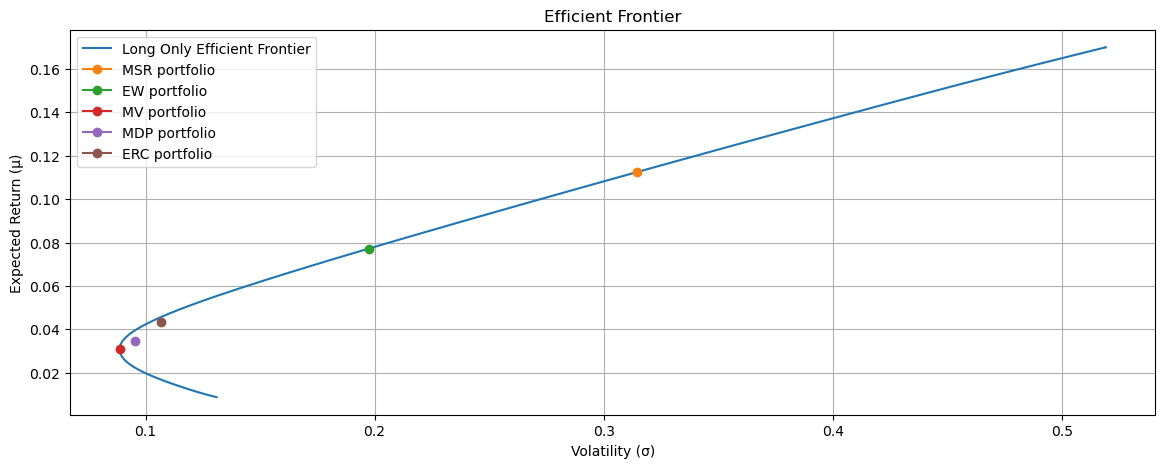

In [42]:
plt.figure(figsize=(14, 5))
plt.plot(volatilities_long_only, expected_returns_long_only, linestyle='-', label="Long Only Efficient Frontier")
plt.plot(sigma_brute, mu_brute, marker = 'o', label="MSR portfolio")
plt.plot(volatility_equally_weighted, expected_return_equally_weighted, marker = 'o', label="EW portfolio")
plt.plot(volatility_minimum_variance, expected_return_minimum_variance, marker = 'o', label="MV portfolio")
plt.plot(volatility_most_diversified, expected_return_most_diversified, marker = 'o', label="MDP portfolio")
plt.plot(volatility_erc, expected_return_erc, marker = 'o', label="ERC portfolio")
plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.title("Efficient Frontier")
plt.legend()
plt.grid(True)
plt.show()